In [3]:
import numpy as np
import opt_dual_mac_cov as cov
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm
from tabulate import tabulate

### MISO System Verification

In [58]:
mat=scipy.io.loadmat('MISO/H_all.mat')
H_list_all=mat['H_all']

M, K, n = H_list_all.shape
H_list_all=np.sqrt(10**(-13.5)) * H_list_all
# sizof_H_list=len(H_list)
# #H_list=sum(H_list[i] for i in range(sizof_H_list))
# #H_list=H_list/sizof_H_list
# #print(H_list)
# H_list=[H_list[:, k].reshape(-1, 1) for k in range(H_list.shape[1])]
# #H_list=[H_list[m].reshape(-1,1) for m in range(H_list.shape[0])]
# print(H_list)

# Power list in dBm and converted to linear scale
pdbm_list = list(range(-10, 55, 5))
p_list = [10 ** ((p - 30) / 10) for p in pdbm_list]

sigma2 = 10**(-13.5)  # noise power
q = [1] * K  # QoS weights (assuming same for all users)

# For storing sum-rate per power level, averaged across n channels
sum_rate_opt_list_avg = np.zeros(len(p_list))

# Iterate over n different channel matrices
for i in tqdm(range(len(H_list_all[0][0])), desc="Processing channel realizations", unit="iteration"):
    # Get H for this iteration
    H = H_list_all[:, :, i]

    # Convert H to H_list (a list of user channel column vectors)
    H_list = [H[:, k].reshape(-1, 1) for k in range(H.shape[1])]

    # Compute sum-rate for all power levels
    sum_rate_opt_list = []
    for p in p_list:
        optimal_Q = cov.optimal_dual_mac_covariances(H_list, p, q, sigma2)[0]
        sum_rate = cov.sum_rate(optimal_Q, H_list, q, sigma2)
        sum_rate_opt_list.append(sum_rate)

    # Add to running average
    sum_rate_opt_list_avg += np.array(sum_rate_opt_list)

# Average over n iterations
sum_rate_opt_list_avg /= n


Processing channel realizations: 100%|██████████| 100/100 [4:17:31<00:00, 154.52s/iteration]  


In [59]:
mat=scipy.io.loadmat('MISO/WSR_avg.mat')
wsr=mat['WSR_avg']

In [60]:
# Combine and tabulate
combined = list(zip(pdbm_list, wsr.T,sum_rate_opt_list_avg))
table=tabulate(combined, headers=["P(dBm)", "MISO", "MIMO"])
print(table)
np.save(f'{M}mx{K}k', H_list_all)
with open(f'{M}mx{K}k_table.txt', 'w') as f:
    f.write(table)

  P(dBm)         MISO         MIMO
--------  -----------  -----------
     -10   0.00290647   0.00290561
      -5   0.00917932   0.00916754
       0   0.0288962    0.0287871
       5   0.0901995    0.0891236
      10   0.274058     0.26595
      15   0.781689     0.738029
      20   2.02206      1.88166
      25   4.7179       4.34571
      30   9.5855       8.77906
      35  16.66        15.346
      40  25.3238      23.6166
      45  34.7865      32.8851
      50  44.5785      42.603


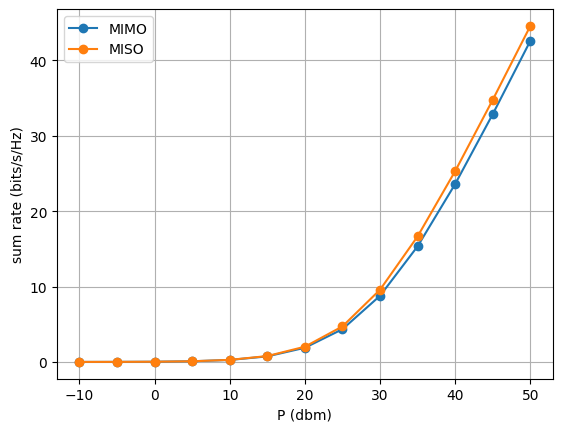

In [61]:
plt.plot(pdbm_list,sum_rate_opt_list_avg,'o-',label='MIMO')
plt.plot(pdbm_list,wsr.T,'o-',label='MISO')
plt.ylabel('sum rate (bits/s/Hz)')
plt.xlabel('P (dbm)')
plt.grid()
plt.legend()
plt.savefig(f'MISO_sum_rate_{M}mx{K}k.png')
plt.show()

Calculates sum-rate for a given power value

In [62]:
P = 1  # Total power constraint
sigma2= 10**(-13.5) # noise var
q=[1 for i in range(1,len(H_list)+1)] # QoS
optimal_Q, t_star, i_star, eg, ev, grad = cov.optimal_dual_mac_covariances(H_list, P, q, sigma2)
#print(f"tstar: {t_star}\nistar: {i_star}\nevec: {eg}\neval: {ev}\ngrad: {grad}")

# print("Optimal Covariance Matrices:")
# for idx, Q in enumerate(optimal_Q):
#     print(f"User {idx + 1}:\n{Q}\n")
# Compute and print optimized sum rate
#print(ref.sum_rate(optimal_Q, H_list,q, sigma2))

sum_rate_opt = cov.sum_rate(optimal_Q, H_list,q, sigma2)
#sum_rate_opt = np.linalg.norm(ref.f(optimal_Q, H_list, sigma2))
print(f"Optimized Sum Rate: {sum_rate_opt}")

Optimized Sum Rate: 8.052608651967036


### MIMO BC with multiple antennas on user side

In [93]:
K=4
M=4
N=4


# Power list in dBm and converted to linear scale
pdbm_list = list(range(-10, 55, 5))
p_list = [10 ** ((p - 30) / 10) for p in pdbm_list]

sigma2 = 10**(-13.5)  # noise power
q = [1] * K  # QoS weights (assuming same for all users)

# For storing sum-rate per power level, averaged across n channels
sum_rate_opt_list_avg = np.zeros(len(p_list))
H_list_all=[]
# Iterate over n different channel matrices
for i in tqdm(range(100), desc="Processing channel realizations", unit="iteration"):
    H_list=np.random.randn(K, M, N) + 1j * np.random.randn(K, M, N)
    H_list=np.sqrt(10**(-13.5))*H_list
    H_list_all.append(H_list)
    # Compute sum-rate for all power levels
    sum_rate_opt_list = []
    for p in p_list:
        optimal_Q = cov.optimal_dual_mac_covariances(H_list, p, q, sigma2)[0]
        sum_rate = cov.sum_rate(optimal_Q, H_list, q, sigma2)
        sum_rate_opt_list.append(sum_rate)

    # Add to running average
    sum_rate_opt_list_avg += np.array(sum_rate_opt_list)

# Average over n iterations
sum_rate_opt_list_avg /= n


Processing channel realizations: 100%|██████████| 100/100 [18:10<00:00, 10.91s/iteration]


In [94]:
# Combine and tabulate
combined = list(zip(pdbm_list,sum_rate_opt_list_avg))
table=tabulate(combined, headers=["P(dBm)", "MIMO"])
print(table)
np.save(f'{M}mx{N}nx{K}k', H_list_all)
with open(f'{M}mx{N}nx{K}k_table.txt', 'w') as f:
    f.write(table)

  P(dBm)         MIMO
--------  -----------
     -10   0.00371101
      -5   0.0117013
       0   0.0366711
       5   0.112869
      10   0.331877
      15   0.901212
      20   2.23052
      25   4.86588
      30   9.14423
      35  14.7399
      40  21.0018
      45  27.5186
      50  34.1216


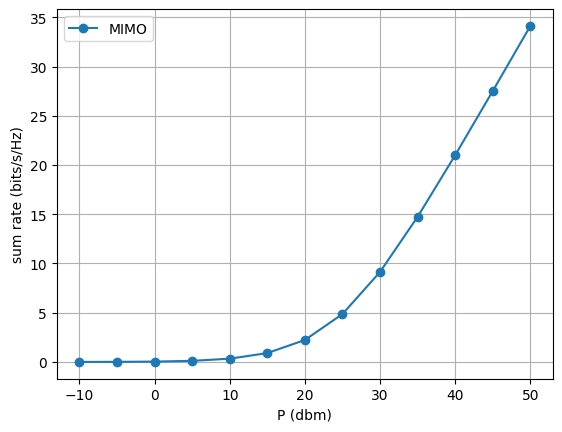

In [95]:
plt.plot(pdbm_list,sum_rate_opt_list_avg,'o-',label='MIMO')
plt.ylabel('sum rate (bits/s/Hz)')
plt.xlabel('P (dbm)')
plt.grid()
plt.legend()
plt.savefig(f'MIMO_sum_rate_{M}mx{N}nx{K}k.png')
plt.show()

### Effect of Receiver Antenna Configuration

In [102]:
import pandas as pd

In [131]:
with open('6mx9k_table.txt', 'r') as f:
    lines = f.readlines()
    
# Skip header line and dashed line
content_lines = [line.strip() for line in lines if line.strip()]
header = content_lines[0].split()
data_lines = content_lines[2:]  # skip dashed line

data = []
for line in data_lines:
    parts = line.split()
    if len(parts) == len(header):
        data.append([float(x) for x in parts])

df = pd.DataFrame(data, columns=header)


In [132]:
with open('6mx2nx9k_table.txt', 'r') as f:
    lines = f.readlines()
    
# Skip header line and dashed line
content_lines = [line.strip() for line in lines if line.strip()]
header = content_lines[0].split()
data_lines = content_lines[2:]  # skip dashed line

data = []
for line in data_lines:
    parts = line.split()
    if len(parts) == len(header):
        data.append([float(x) for x in parts])

df2 = pd.DataFrame(data, columns=header)

In [ ]:
with open('4mx3nx4k_table.txt', 'r') as f:
    lines = f.readlines()
    
# Skip header line and dashed line
content_lines = [line.strip() for line in lines if line.strip()]
header = content_lines[0].split()
data_lines = content_lines[2:]  # skip dashed line

data = []
for line in data_lines:
    parts = line.split()
    if len(parts) == len(header):
        data.append([float(x) for x in parts])

df3 = pd.DataFrame(data, columns=header)

In [116]:
with open('4mx4nx4k_table.txt', 'r') as f:
    lines = f.readlines()
    
# Skip header line and dashed line
content_lines = [line.strip() for line in lines if line.strip()]
header = content_lines[0].split()
data_lines = content_lines[2:]  # skip dashed line

data = []
for line in data_lines:
    parts = line.split()
    if len(parts) == len(header):
        data.append([float(x) for x in parts])

df4 = pd.DataFrame(data, columns=header)

In [133]:
new_df = pd.DataFrame({
    'N=1': df['MIMO'],
    'N=2': df2['MIMO']
})
print(new_df)
new_df.to_csv("6mx9k.csv", index=False)

          N=1        N=2
0    0.002906   0.003814
1    0.009168   0.012026
2    0.028787   0.037687
3    0.089124   0.116033
4    0.265950   0.342232
5    0.738029   0.943265
6    1.881660   2.404460
7    4.345710   5.490140
8    8.779060  10.880000
9   15.346000  18.498600
10  23.616600  27.518800
11  32.885100  37.155200
12  42.603000  47.013300


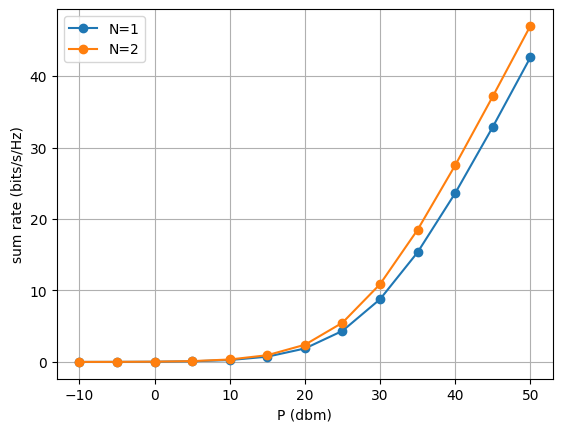

In [134]:
plt.plot(pdbm_list,df["MIMO"],'o-',label='N=1')
plt.plot(pdbm_list,df2["MIMO"],'o-',label='N=2')
# plt.plot(pdbm_list,df3["MIMO"],'o-',label='N=3')
# plt.plot(pdbm_list,df4["MIMO"],'o-',label='N=4')
plt.ylabel('sum rate (bits/s/Hz)')
plt.xlabel('P (dbm)')
plt.grid()
plt.legend()
plt.savefig(f'MIMO_sum_rate_6mx9k.png')
plt.show()

Generate latex table

In [177]:
with open('6mx9k_table.txt', 'r') as f:
    lines = f.readlines()
    
# Skip header line and dashed line
content_lines = [line.strip() for line in lines if line.strip()]
header = content_lines[0].split()
data_lines = content_lines[2:]  # skip dashed line

data = []
for line in data_lines:
    parts = line.split()
    if len(parts) == len(header):
        data.append([float(x) for x in parts])

daf = pd.DataFrame(data, columns=header)

latex_table = daf.to_latex(index=False)  # Set index=False to exclude the row numbers
print(latex_table)

\begin{tabular}{rrr}
\toprule
P(dBm) & MISO & MIMO \\
\midrule
-10.000000 & 0.002906 & 0.002906 \\
-5.000000 & 0.009179 & 0.009168 \\
0.000000 & 0.028896 & 0.028787 \\
5.000000 & 0.090200 & 0.089124 \\
10.000000 & 0.274058 & 0.265950 \\
15.000000 & 0.781689 & 0.738029 \\
20.000000 & 2.022060 & 1.881660 \\
25.000000 & 4.717900 & 4.345710 \\
30.000000 & 9.585500 & 8.779060 \\
35.000000 & 16.660000 & 15.346000 \\
40.000000 & 25.323800 & 23.616600 \\
45.000000 & 34.786500 & 32.885100 \\
50.000000 & 44.578500 & 42.603000 \\
\bottomrule
\end{tabular}



Error in MIMO when compared with MISO 

In [178]:
((daf["MISO"]-daf["MIMO"])/daf["MISO"]).mean()

0.04464893047686486

### Convergence Analysis

In [5]:
import convergence_analysis as c_a
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm
from tabulate import tabulate

In [6]:
sigma2 = 10**(-13.5)  # noise power

sum_rate_iter=[]
mat_dim=[(4,1,4),(4,2,4),(4,2,8),(4,1,8),(5,1,5),(5,3,5),(6,1,9),(6,2,9)]
for (m,n,k) in tqdm(mat_dim, desc="Processing", unit="iteration"):
    if n==1:
        data = np.load(f"{m}mx{k}k.npy")
    else:
        data = np.load(f"{m}mx{n}nx{k}k.npy")
    H = data[:, :, 0]
    q = [1] * k  # QoS weights (assuming same for all users)
    p= 0.01 #10dBm
    # Convert H to H_list (a list of user channel column vectors)
    H_list = [H[:, k].reshape(-1, 1) for k in range(H.shape[1])]
    sum_rate_iter.append(c_a.optimal_dual_mac_covariances(H_list, p, q, sigma2)[1])


Processing: 100%|██████████| 8/8 [00:15<00:00,  1.97s/iteration]


In [7]:
sum_rate_iter

[[0.0,
  0.1288232613461533,
  0.1288239959574678,
  0.1288239959574678,
  0.12882399596184632,
  0.12882399596184632,
  0.12882399596184632],
 [0.0,
  2.376015107947619,
  3.2495670458715264,
  3.706340487307652,
  3.972956177323095,
  3.9729686797911654,
  3.972984190923771,
  3.9729898221083424,
  3.972994834535772,
  3.972997388281536,
  3.972997388281536,
  3.9729988908005844,
  3.9729988908005844,
  3.9729998844769394],
 [0.0,
  2.450700487944681,
  3.342549730648048,
  3.856801726143544,
  4.196666607127709,
  4.436017227601585,
  4.562302689393644,
  4.659603955727307,
  4.716135337511793,
  4.716501134060952,
  4.716537849335447,
  4.716547322159124,
  4.7165578459285475,
  4.716563230895953,
  4.716563230895953,
  4.716569940764367,
  4.716574521064281,
  4.716574521064281,
  4.716579283017465],
 [0.0,
  0.1622175533677732,
  0.16221846794268746,
  0.16221846794268746,
  0.1622184679481388,
  0.1622184679481388,
  0.16221846794814004],
 [0.0,
  0.17332763443734547,
  0.173328

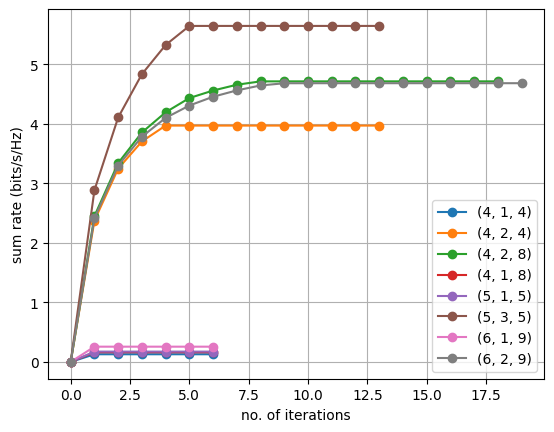

In [8]:
for i in range(len(sum_rate_iter)):
    plt.plot([j for j in range(len(sum_rate_iter[i]))],sum_rate_iter[i],'o-',label=f'{mat_dim[i]}')
# plt.plot(pdbm_list,df3["MIMO"],'o-',label='N=3')
# plt.plot(pdbm_list,df4["MIMO"],'o-',label='N=4')
plt.ylabel('sum rate (bits/s/Hz)')
plt.xlabel('no. of iterations')
plt.grid()
plt.legend()
plt.savefig(f'convergence_plot_2.png')
plt.show()